In [15]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Download data

In [4]:
imdb, info = tfds.load('imdb_reviews', 
                       with_info = True, 
                       as_supervised = True)

Shuffling and writing examples to /home/leo/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOEJFV1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/leo/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOEJFV1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/leo/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOEJFV1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/leo/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [7]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
testing_sentences = []
training_labels = []
testing_labels = []

for sentence, label in train_data:
    training_sentences.append(str(sentence.numpy()))
    training_labels.append(label.numpy())
    
for sentence, label in test_data:
    testing_sentences.append(str(sentence.numpy()))
    testing_labels.append(label.numpy())

In [13]:
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [16]:
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Preprocessing

In [18]:
#Parameters
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_token = '<OOV>'

##### Tokenizer

In [24]:
tokenizer = Tokenizer(num_words = vocab_size,
                      oov_token = oov_token)

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

##### Padding

In [25]:
padded = pad_sequences(sequences, 
                       maxlen = max_length,
                       truncating = trunc_type)

testing_padded = pad_sequences(testing_sequences, 
                               maxlen = max_length,
                               truncating = trunc_type)

### Model

In [26]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim, 
                              input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

history = model.fit(padded,
                    training_labels,
                    epochs = 10, 
                    validation_data = (testing_padded, testing_labels)) 

Epoch 1/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2480 - accuracy: 0.9008 - val_loss: 0.4109 - val_accuracy: 0.8186
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1045 - accuracy: 0.9717 - val_loss: 0.5037 - val_accuracy: 0.8062
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0263 - accuracy: 0.9961 - val_loss: 0.6015 - val_accuracy: 0.8043
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.6824 - val_accuracy: 0.8057
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7369 - val_accuracy: 0.8083
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 8.6632e-04 - accuracy: 1.0000 - val_loss: 0.7938 - val_accuracy: 0.8078
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 4.9387e-04 - accuracy: 1.0000 - val_loss: 0.8394 - val_accuracy: 0.809

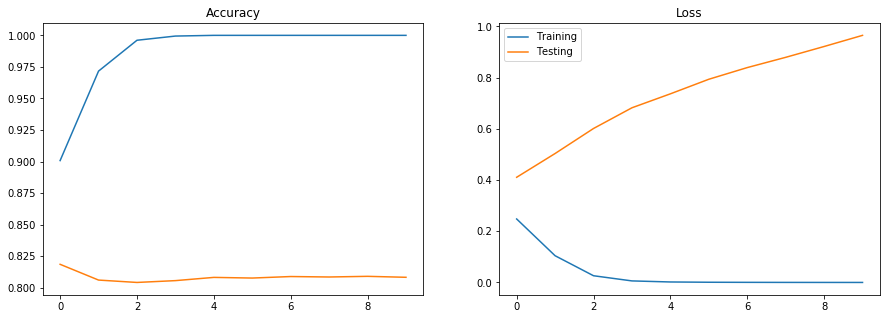

In [32]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[0].plot(history.history['accuracy'], label='Training')
ax[0].plot(history.history['val_accuracy'], label='Testing')
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label='Training')
ax[1].plot(history.history['val_loss'], label='Testing')
ax[1].set_title('Loss')

plt.legend()
plt.show()

Clearly overfitted

### Embedding

In [33]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [37]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

Import the embedding to project them into https://projector.tensorflow.org

In [40]:
import io

out_v = io.open('data/vecs.tsv','w',encoding = 'utf-8')
out_m = io.open('data/meta.tsv','w',encoding = 'utf-8')

for word_num in range(1,vocab_size):
    word = reverse_word_index[word_num]
    embedding = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embedding]) + '\n')

out_v.close()
out_m.close()

![Embedding](data/embedding.png)